Setting Up Project

In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Choosing File Path.
Dataset is Taken from PlantVillage Dataset.

In [2]:
#base_dir = '/home/yearat/Documents/Documents/Jupyter Notebooks/datasets/Process/'
base_dir = '/home/yearat/Documents/Documents/Jupyter Notebooks/datasets/Potato/'

Augmentation and Train / Validation Generator

In [3]:

IMAGE_SIZE = 224 
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.4,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory( 
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset='training'
)
val_generator = datagen.flow_from_directory( 
    base_dir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 1698 images belonging to 3 classes.
Found 424 images belonging to 3 classes.


Different Classes Are in Different Folders.
This Generates Labels from Folder Names.

In [4]:
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


Model Setup and Training

In [5]:

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, 
    weights='imagenet'
)

In [6]:
base_model.trainable=False 
model = tf.keras.Sequential([ 
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.Dense(3, #no.of classes
                        activation='softmax')
])

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [8]:
epochs = 10 
history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data=val_generator
)

Epoch 1/10
27/27 [==============================] - 42s 1s/step - loss: 1.2278 - accuracy: 0.6968 - val_loss: 0.3265 - val_accuracy: 0.8892
Epoch 2/10
27/27 [==============================] - 17s 625ms/step - loss: 0.2417 - accuracy: 0.8982 - val_loss: 0.2315 - val_accuracy: 0.8962
Epoch 3/10
27/27 [==============================] - 17s 613ms/step - loss: 0.1817 - accuracy: 0.9296 - val_loss: 0.1400 - val_accuracy: 0.9528
Epoch 4/10
27/27 [==============================] - 16s 611ms/step - loss: 0.1599 - accuracy: 0.9392 - val_loss: 0.1662 - val_accuracy: 0.9363
Epoch 5/10
27/27 [==============================] - 17s 614ms/step - loss: 0.1629 - accuracy: 0.9467 - val_loss: 0.1315 - val_accuracy: 0.9458
Epoch 6/10
27/27 [==============================] - 17s 616ms/step - loss: 0.1412 - accuracy: 0.9491 - val_loss: 0.0789 - val_accuracy: 0.9717
Epoch 7/10
27/27 [==============================] - 16s 609ms/step - loss: 0.0816 - accuracy: 0.9704 - val_loss: 0.1053 - val_accuracy: 0.9693
Ep

Displaying Model's Metrics

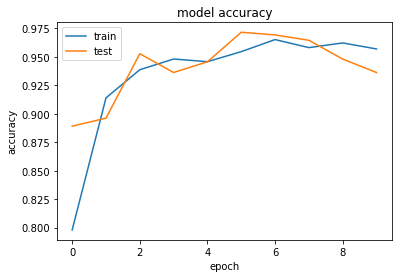

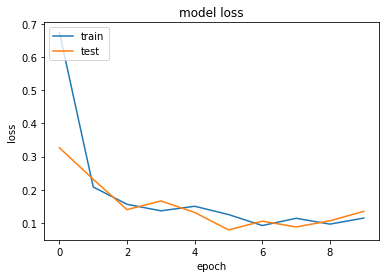

In [9]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Conversion and save as TFlite Model

In [11]:
saved_model_dir = '' #means current directory
tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('model.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)

INFO:tensorflow:Assets written to: assets
